Welcome to this notebook, where I build a model using different machine learning techniques for time series forecasting, to foreecast sales of a store in Ecuador. Here, I build upon the previous results from the first notebook "fit_linearregression.ipynb", where I just tried to forecast the sales using linear rgeression.

In this notebook, I will try to engineer the features differently, and will use a hybrid approach, using linear regression to model the time evolution and a random forest or XGBoost to model the dependencies arising from categories (for e.g, product type, store number etc).

I prepared this notebook also as preparation for the Kaggle competition: "Store Sales - Time Series Forecasting" (https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview). The data I use here was obtained from this competition, and is also available as a compressed folder in this repository. In this notebook, I will use time-series forecasting to predict the sales using data from Corporación Favorita, a large Ecuadorian-based grocery retailer. 

In [275]:
import pandas as pd
full_set = pd.read_csv("train.csv", parse_dates=["date"]) # importing the train set as the full set, to be split below into train and test sets

full_set["date"] = pd.to_datetime(full_set["date"]) # converting the date column to pandas datetype

train_test_split_date = pd.to_datetime("2017-07-31") # the date to split the data into train and test

train_set = full_set[full_set["date"]<=train_test_split_date]
test_set = full_set[full_set["date"]>train_test_split_date]

In [276]:
train_set # viewing the dataset

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
2974153,2974153,2017-07-31,9,POULTRY,470.513,1
2974154,2974154,2017-07-31,9,PREPARED FOODS,61.940,0
2974155,2974155,2017-07-31,9,PRODUCE,1517.552,6
2974156,2974156,2017-07-31,9,SCHOOL AND OFFICE SUPPLIES,56.000,6


Firstly, I model only the time evolution of sales (trend and seasonality) using linear regression. For this, the time dummy and Fourier terms are constructed using the "DeterministicProcess" and "CalendarFourier" modules on "statsmodels". As in the previous notebook, I use a linear trend and two Fourier terms at weekly and yearly frequencies. I explain my motivation for these choices in "fit_linearregression.ipynb", so please take a look at this notebook if curious.

In [277]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

unique_dates = train_set["date"].unique() # we only care about the unique dates here as we are trying to model the time evolution

# Using DeterministicProcess to generate time dummies (linear and quadratic with order=1) 
# and two Fourier elements for seasonal effects at yearly and weekly frequencies  

fourier1 = CalendarFourier(freq="YE", order=1)  
fourier2 = CalendarFourier(freq="W", order=1)  

train_set_copy = train_set.copy()
train_set_copy.set_index("date")

dp = DeterministicProcess(
    index=unique_dates,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    additional_terms=[fourier1,fourier2],  
    # additional_terms=[fourier2],  
    drop=True,           # drop terms if necessary to avoid collinearity
)

X1 = dp.in_sample()


In [278]:
X1

,const,trend,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)"
2013-01-01,1.0,1.0,0.000000,1.000000,0.781831,0.623490
2013-01-02,1.0,2.0,0.017213,0.999852,0.974928,-0.222521
2013-01-03,1.0,3.0,0.034422,0.999407,0.433884,-0.900969
2013-01-04,1.0,4.0,0.051620,0.998667,-0.433884,-0.900969
2013-01-05,1.0,5.0,0.068802,0.997630,-0.974928,-0.222521
...,...,...,...,...,...,...
2017-07-27,1.0,1665.0,-0.409356,-0.912375,0.433884,-0.900969
2017-07-28,1.0,1666.0,-0.425000,-0.905193,-0.433884,-0.900969
2017-07-29,1.0,1667.0,-0.440519,-0.897743,-0.974928,-0.222521
2017-07-30,1.0,1668.0,-0.455907,-0.890028,-0.781831,0.623490


In the given datasets, there is also additional information available. For example "holidays.csv" contains the list of public holidays in Ecuador, which can influence the sales in a grocery store. So I also add this information to the modelling of the time evolution of sales

In [279]:
holidays = pd.read_csv("holidays_events.csv") # loading the data for the list of holidays

# holidays["transferred"] is a boolean series, which says if a holiday was transferred or not
# if holidays["transferred"]==True, then it means that the holiday was transferred and it was not a holiday on this date
# so I just remove all the dates where the holiday was transferred as that's what's relevant
holidays = holidays[~holidays["transferred"]] 

In [280]:
holiday_dates = holidays["date"]

# creating a new column in X1, which stores 1 when the date index is a holiday and 0 otherwise
X1["is_holiday"] = X1.index.isin(holiday_dates).astype(int) 

C:\Users\saiha\AppData\Local\Temp\ipykernel_10716\1584483321.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X1["is_holiday"] = X1.index.isin(holiday_dates).astype(int)


The dataset "holidays.csv" also contains a type of holidays/events of the type "Work Day". These represent extra working days to compensate bridge days between holidays, which are usually taken as holidays by people. So whenever there is a compensation or of the type "Work Day", I assign the value of -1 for the column X1["is_holiday"], as it has the opposite effect of a holiday

In [281]:
compensation_days = holidays["date"][holidays["type"]=="Work Day"]

for date in compensation_days:
    X1.loc[X1.index == pd.to_datetime(date),"is_holiday"] = -1

Another modification is needed for the target sales. In the original sales data, the date is repeated many times, as there is an entry for each date, each product family and each store number. But to capture the evolution with time, it would not make sense to have many entries at the same date. So for this purpose I fit the evolution to the median of sales on a particular day. The contributions from non-temporal origins will be included in the next stage.

In [282]:
y1 = train_set.groupby(["date"])['sales'].median()

Fitting the median sales on a day to the linear trend, Fourier terms and holiday features using linear regression 

In [283]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X1, y1)

In [284]:
y_pred1 = model.predict(X1)
y_pred1 = pd.Series(y_pred1, index=y1.index)

Text(0, 0.5, 'sales')

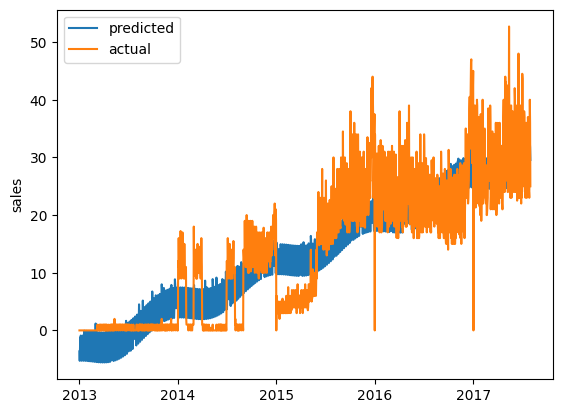

In [285]:
import matplotlib.pyplot as plt

plt.plot(y_pred1, label="predicted")
plt.plot(y1,label="actual")
# plt.plot(y1-y_pred1)
plt.legend()
plt.ylabel("sales")


In the above plot, we can see that some of the time evolution is captured through our model, but of course there is a lot more information which the model cannot capture. Before going to the next step, let's plot the periodograms for the actual sales and the residual sales (actual-predicted) to see if we are able to capture the seasonality well. 

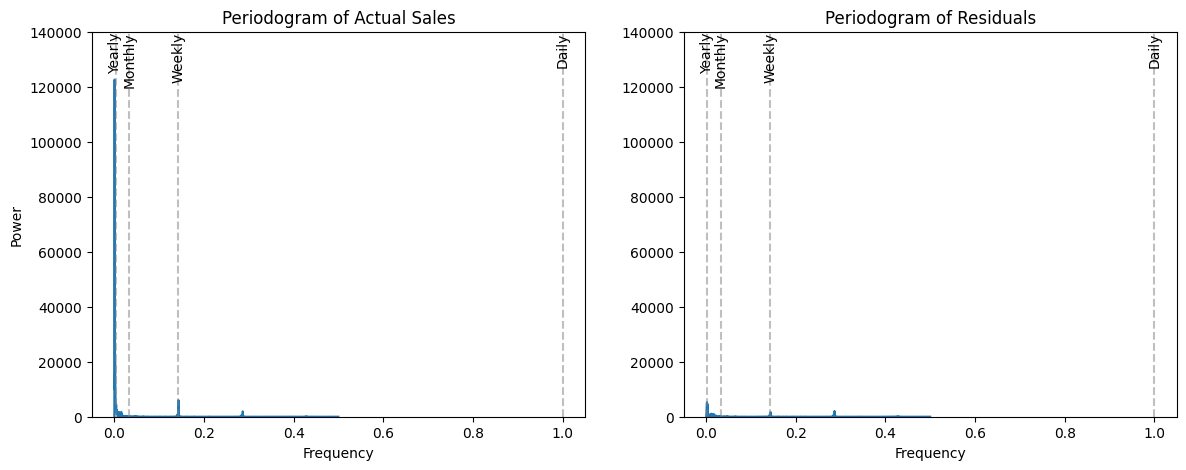

In [286]:
from scipy.signal import periodogram
freq_y1, power_y1 = periodogram(y1, fs=1.0)
freq_resid, power_resid = periodogram(y1 - y_pred1, fs=1.0)

# Define known periods
periods = {
    "Yearly": 1/365,
    "Monthly": 1/30,
    "Weekly": 1/7,
    "Daily": 1
}

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# -------- Plot for y1 --------
axs[0].plot(freq_y1, power_y1)
axs[0].set_title("Periodogram of Actual Sales")
axs[0].set_ylim([0, 140000])
axs[0].set_xlabel("Frequency")
axs[0].set_ylabel("Power")

for label, freq in periods.items():
    axs[0].axvline(x=freq, color='gray', linestyle='--', alpha=0.5)
    axs[0].text(freq, axs[0].get_ylim()[1]*1, label, rotation=90, color='black',
                va='top', ha='center', clip_on=False)

# -------- Plot for residuals --------
axs[1].plot(freq_resid, power_resid)
axs[1].set_title("Periodogram of Residuals")
axs[1].set_ylim([0, 140000])
axs[1].set_xlabel("Frequency")

for label, freq in periods.items():
    axs[1].axvline(x=freq, color='gray', linestyle='--', alpha=0.5)
    axs[1].text(freq, axs[1].get_ylim()[1]*1, label, rotation=90, color='black',
                va='top', ha='center', clip_on=False)

So it can be seen in the above plot, that the power of the yearly features has drastically reduced in the residual periodogram. Even the weekly feature has been captured, which means that seasonalities of the sales data has been well captured with the inclusion of the two Fourier terms

In the above plots, we could see that the predictions capture some of the time evolution, but of course many other features are still not constrained. To improve the fit here, we can make use of the other information available, namely the categorical data, for example, the store number or the product type. 

However, the issue with categorical features is that they are not necessarily well modeled with linear regression. One way to do it is to use one-hot encoding, but this obviosuly creates the issue of having a lot of columns. If suppose there are 1000 types of products, one-hot encoding would create 1000 new columns in our input vector. This is obviously not practical. 

Another way to deal with categories is to use label encoding, where an integer is assigned to each type. But using this with linear regression would not make sense, as we are inherently implying that a product type with a larger number has a higher value, which does not make any sense. So for this purpose, we can turn to a different machine learning models, specifically ones which use decision trees. 

Decision trees do not work in the same way as linear regression, as they use a lot of conditions to predict values. As the inherent value is not important, we can still use label encoding here. 

So in the next step, I willl fit the residual sales (after removing the time part) to the other categorical features using a Random Forest model.

In [287]:
sales_set = train_set_copy[["date", "sales"]].set_index("date")
# y_pred1.name = "y_pred1"
y_pred1 = pd.DataFrame(y_pred1)

In [288]:
# doing an inner join of the predicted sales from the first model for each entry in the original data set

sales_set = sales_set.merge(y_pred1, on="date", how="left")
sales_set = sales_set.rename(columns={0:"y_pred1"})

In [289]:
sales_set # sales: actual sales, y_pred1: predictions from the linear regression model

,sales,y_pred1
date,,
2013-01-01,0.000,-3.632401
2013-01-01,0.000,-3.632401
2013-01-01,0.000,-3.632401
2013-01-01,0.000,-3.632401
2013-01-01,0.000,-3.632401
...,...,...
2017-07-31,470.513,29.551355
2017-07-31,61.940,29.551355
2017-07-31,1517.552,29.551355


In [290]:
y2 = sales_set
y2["sales"] = sales_set["sales"]-sales_set["y_pred1"] # computing the residual of actual and prediction from linear regression
y2 = y2.drop(columns="y_pred1")

In [291]:
y2

,sales
date,
2013-01-01,3.632401
2013-01-01,3.632401
2013-01-01,3.632401
2013-01-01,3.632401
2013-01-01,3.632401
...,...
2017-07-31,440.961645
2017-07-31,32.388645
2017-07-31,1488.000645


In [292]:
X2 = train_set

X2 = X2.reset_index().set_index("date") # preparing the input for the next step

In [293]:
X2 = X2.drop(columns=["index","id","sales"])

In the dataset, we also have oil prices available for select dates in the dataset. Ecuador is heavily dependent on oil, so the oil prices have a good chance in influencing the sales of a store in Ecuador. So we can include this information in our model as well. 

In [294]:
oil_prices = pd.read_csv("oil.csv")
oil_prices["date"] = pd.to_datetime(oil_prices["date"])
oil_prices = oil_prices.reset_index().set_index("date")
oil_prices = oil_prices.drop(columns="index")

In [295]:
X2 = X2.merge(oil_prices, right_index=True,left_index=True,how="left") # merging the oil prices to the input matrix

In [296]:
X2

,store_nbr,family,onpromotion,dcoilwtico
date,,,,
2013-01-01,1,AUTOMOTIVE,0,NaN
2013-01-01,1,BABY CARE,0,NaN
2013-01-01,1,BEAUTY,0,NaN
2013-01-01,1,BEVERAGES,0,NaN
2013-01-01,1,BOOKS,0,NaN
...,...,...,...,...
2017-07-31,9,POULTRY,1,50.21
2017-07-31,9,PREPARED FOODS,0,50.21
2017-07-31,9,PRODUCE,6,50.21


In [297]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
le.fit(X2["family"].unique())
X2["family"] = le.transform(X2["family"])  

In [298]:
y2

,sales
date,
2013-01-01,3.632401
2013-01-01,3.632401
2013-01-01,3.632401
2013-01-01,3.632401
2013-01-01,3.632401
...,...
2017-07-31,440.961645
2017-07-31,32.388645
2017-07-31,1488.000645


In [299]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


# model2 = XGBRegressor().fit(X2,y2)


model2 = RandomForestRegressor(
    n_estimators=100,     # keep small for test run
    max_depth=10,         # prevent infinite depth
    n_jobs=-1,            # use all cores
    verbose=1             # optional: shows progress
)

model2.fit(X2, y2["sales"])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomForestRegressor(max_depth=10, n_jobs=-1, verbose=1)

In [300]:
y_pred2 = model2.predict(X2)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.2s finished


In [301]:
y_pred = sales_set["y_pred1"] + y_pred2

In [302]:
y_pred

date
2013-01-01     -11.819093
2013-01-01     -19.011445
2013-01-01     -14.311188
2013-01-01     915.311657
2013-01-01     -18.384844
                 ...     
2017-07-31     579.483697
2017-07-31      85.924172
2017-07-31    1456.000506
2017-07-31      61.023299
2017-07-31      16.197239
Name: y_pred1, Length: 2974158, dtype: float64

In [303]:
y = pd.DataFrame({"target_sales":train_set["sales"].values},index=X2.index)

In [304]:
train_set["sales"]

0             0.000
1             0.000
2             0.000
3             0.000
4             0.000
             ...   
2974153     470.513
2974154      61.940
2974155    1517.552
2974156      56.000
2974157      12.000
Name: sales, Length: 2974158, dtype: float64

In [305]:
y

,target_sales
date,
2013-01-01,0.000
2013-01-01,0.000
2013-01-01,0.000
2013-01-01,0.000
2013-01-01,0.000
...,...
2017-07-31,470.513
2017-07-31,61.940
2017-07-31,1517.552


Text(0, 0.5, 'Sales')

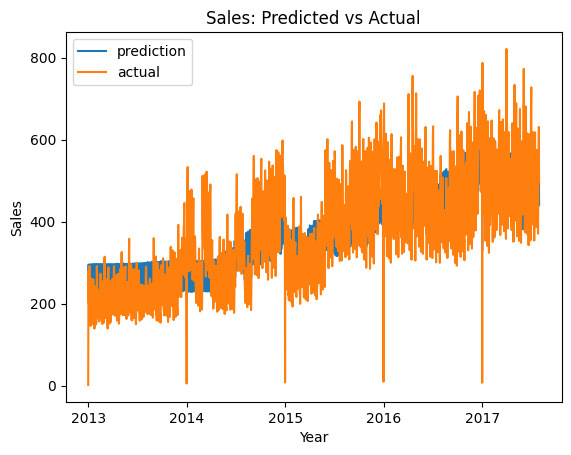

In [306]:
y_avg = y.groupby("date").mean()
y_pred_avg = y_pred.groupby("date").mean()

plt.plot(y_pred_avg,label='prediction')
plt.plot(y_avg,label='actual')
plt.legend()
plt.title("Sales: Predicted vs Actual")
plt.xlabel("Year")
plt.ylabel("Sales")

Compared to the fit using only linear regression in the previous notebook, the fit does look much better. Now we can also compute the predicted sales for the test data and compare them.

In [307]:
# test_set = pd.read_csv("test.csv", parse_dates=["date"])

test_set = full_set[full_set["date"]>train_test_split_date]

y_test = pd.DataFrame({"sales":test_set["sales"].values},index=test_set["date"])
test_set = test_set.drop(columns="sales")
test_set["date"] = pd.to_datetime(test_set["date"]) # converting the date column to pandas datetype

In [308]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# unique_dates = pd.date_range(start=train_set["date"].min(), end =train_set["date"].max(), freq="D")
unique_dates = test_set["date"].unique()

# Using DeterministicProcess to generate time dummies (linear and quadratic with order=2) 
# and two Fourier elements for seasonal effects at yearly and weekly frequencies  

fourier1 = CalendarFourier(freq="YE", order=1)  
fourier2 = CalendarFourier(freq="W", order=1)  

# train_set_copy = train_set.copy()
# train_set_copy.set_index("date")

dp = DeterministicProcess(
    index=unique_dates,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    additional_terms=[fourier1,fourier2],  
    # additional_terms=[fourier2],  
    drop=True,           # drop terms if necessary to avoid collinearity
)

X1_test = dp.in_sample()


In [309]:
X1_test["is_holiday"] = X1_test.index.isin(holiday_dates).astype(int)

for date in compensation_days:
    X1_test.loc[X1_test.index == pd.to_datetime(date),"is_holiday"] = -1

C:\Users\saiha\AppData\Local\Temp\ipykernel_10716\3243925231.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X1_test["is_holiday"] = X1_test.index.isin(holiday_dates).astype(int)


In [310]:
y_pred1_test = model.predict(X1_test)

In [311]:
y_pred1_test = pd.DataFrame(y_pred1_test, index = X1_test.index)

In [312]:
y_pred1_test = y_pred1_test.rename(columns={0:"y_pred1_test"})

In [313]:
y_pred1_test

,y_pred1_test
2017-08-01,-6.744503
2017-08-02,-6.887572
2017-08-03,-5.132808
2017-08-04,-2.767132
2017-08-05,-0.083878
2017-08-06,-2.334960
2017-08-07,-4.524506
2017-08-08,-6.422433
2017-08-09,-6.564655
2017-08-10,-4.809097


In [314]:
X2_test = test_set

X2_test = X2_test.reset_index().set_index("date")

In [315]:
X2_test = X2_test.merge(oil_prices, right_index=True,left_index=True,how="left")
X2_test = X2_test.drop(columns=["index","id"])

In [316]:
# le = LabelEncoder()
# le.fit(X2_test["family"].unique())
X2_test["family"] = le.transform(X2_test["family"])

In [317]:
X2_test

,store_nbr,family,onpromotion,dcoilwtico
date,,,,
2017-08-01,1,0,0,49.19
2017-08-01,1,1,0,49.19
2017-08-01,1,2,0,49.19
2017-08-01,1,3,26,49.19
2017-08-01,1,4,0,49.19
...,...,...,...,...
2017-08-15,9,28,0,47.57
2017-08-15,9,29,1,47.57
2017-08-15,9,30,148,47.57


In [318]:
y_pred2_test = model2.predict(X2_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [319]:
y_pred2_test

array([ -16.14824889,  -20.21185402,  -17.01331615, ..., 2782.74877018,
        194.77390738,  -13.35411536], shape=(26730,))

In [320]:
sales_test = test_set.loc[:,"date"]
sales_test = sales_test.reset_index().set_index("date")

In [321]:
sales_test

,index
date,
2017-08-01,2974158
2017-08-01,2974159
2017-08-01,2974160
2017-08-01,2974161
2017-08-01,2974162
...,...
2017-08-15,3000883
2017-08-15,3000884
2017-08-15,3000885


In [322]:
sales_test["y_pred2_test"] = y_pred2_test

In [323]:
sales_test = sales_test.merge(y_pred1_test,how="left",left_index=True,right_index=True)
sales_test

,index,y_pred2_test,y_pred1_test
2017-08-01,2974158,-16.148249,-6.744503
2017-08-01,2974159,-20.211854,-6.744503
2017-08-01,2974160,-17.013316,-6.744503
2017-08-01,2974161,2249.671485,-6.744503
2017-08-01,2974162,-20.480466,-6.744503
...,...,...,...
2017-08-15,3000883,291.241077,-4.642041
2017-08-15,3000884,96.384817,-4.642041
2017-08-15,3000885,2782.748770,-4.642041
2017-08-15,3000886,194.773907,-4.642041


In [324]:
sales_test

,index,y_pred2_test,y_pred1_test
2017-08-01,2974158,-16.148249,-6.744503
2017-08-01,2974159,-20.211854,-6.744503
2017-08-01,2974160,-17.013316,-6.744503
2017-08-01,2974161,2249.671485,-6.744503
2017-08-01,2974162,-20.480466,-6.744503
...,...,...,...
2017-08-15,3000883,291.241077,-4.642041
2017-08-15,3000884,96.384817,-4.642041
2017-08-15,3000885,2782.748770,-4.642041
2017-08-15,3000886,194.773907,-4.642041


In [325]:
y_pred_test = pd.DataFrame({"predicted_sales": sales_test["y_pred2_test"].values + sales_test["y_pred1_test"].values},index=X2_test.index)
y_pred_test

,predicted_sales
date,
2017-08-01,-22.892752
2017-08-01,-26.956357
2017-08-01,-23.757820
2017-08-01,2242.926982
2017-08-01,-27.224970
...,...
2017-08-15,286.599036
2017-08-15,91.742776
2017-08-15,2778.106730


Text(0, 0.5, 'Sales')

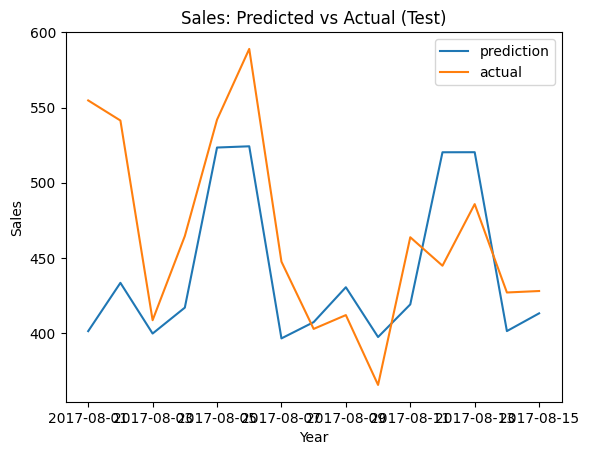

In [326]:
y_test_avg = y_test.groupby("date").mean()
y_pred_test_avg = y_pred_test.groupby("date").mean()

plt.plot(y_pred_test_avg,label='prediction')
plt.plot(y_test_avg,label='actual')
plt.legend()
plt.title("Sales: Predicted vs Actual (Test)")
plt.xlabel("Year")
plt.ylabel("Sales")

Comparing it with the predictions from linear regression, these predictions are much better. 

In [327]:
train_set_pred = train_set.drop(columns="id").set_index("date")

# y_pred.groupby(["date","family"]).mean()
train_set_pred["predicted_sales"] = y_pred

In [328]:
train_set_pred = train_set_pred.groupby(["family","date"]).mean().drop(columns=["store_nbr","onpromotion"]).reset_index()

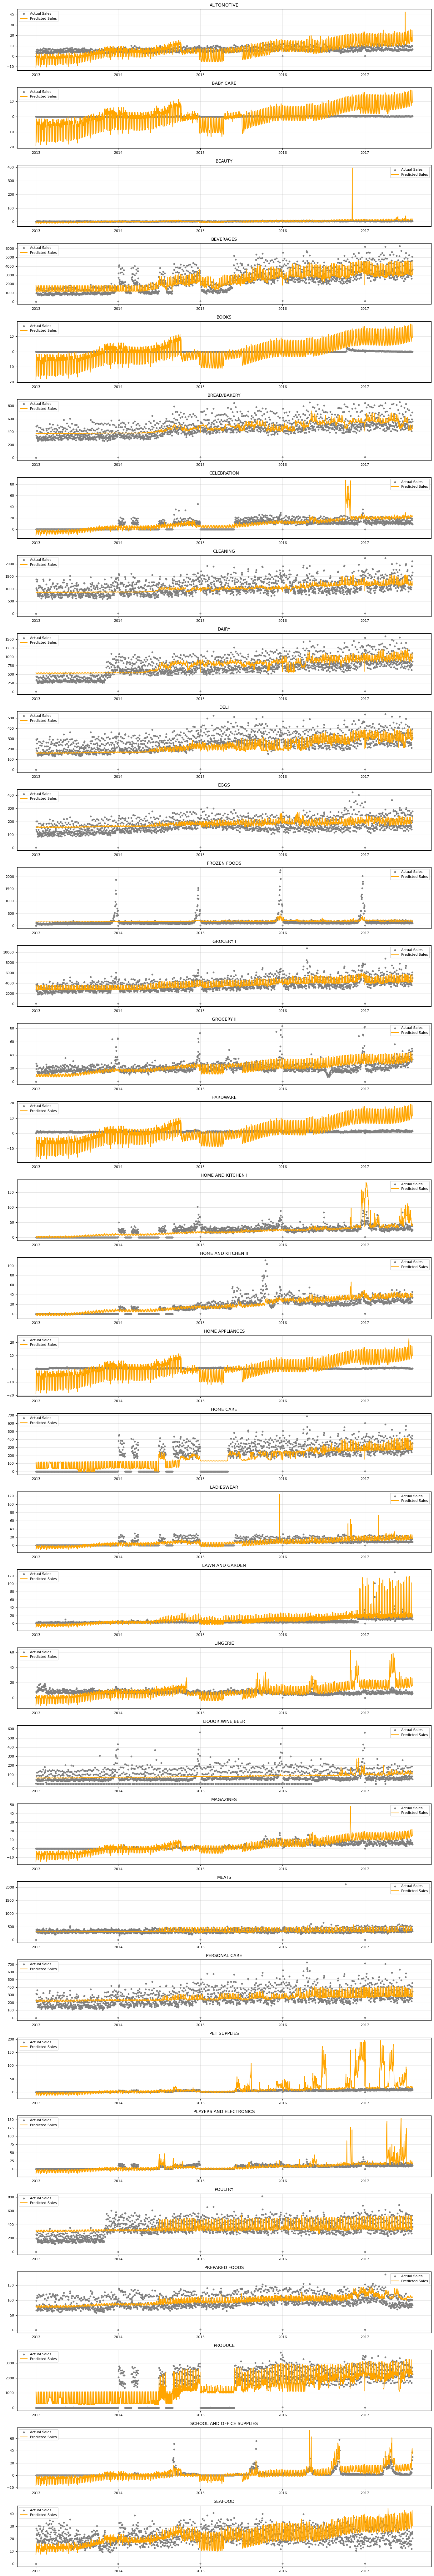

In [329]:
families = train_set_pred["family"].unique()
n_families = len(families)

# Create subplots (not sharing x-axis)
fig, axs = plt.subplots(n_families, 1, figsize=(14, 2.5 * n_families), sharex=False)

# Ensure axs is iterable
if n_families == 1:
    axs = [axs]

# Plot for each family
for ax, fam in zip(axs, families):
    fam_df = train_set_pred[train_set_pred["family"] == fam]

    ax.scatter(fam_df["date"], fam_df["sales"], label="Actual Sales", color='grey',s=10)
    ax.plot(fam_df["date"], fam_df["predicted_sales"], label="Predicted Sales", color='orange')
    
    ax.set_title(fam, fontsize=10)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()

In [330]:
test_set["id"]

2974158    2974158
2974159    2974159
2974160    2974160
2974161    2974161
2974162    2974162
            ...   
3000883    3000883
3000884    3000884
3000885    3000885
3000886    3000886
3000887    3000887
Name: id, Length: 26730, dtype: int64

In [331]:
test_set.columns

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')

In [332]:
# predictions = sales_test[]
# test_set_ids = test_set.loc[:,"id"]
# test_set_ids.reset_index().set_index(1)

predictions = test_set.drop(columns=["store_nbr","family","onpromotion"])
predictions = predictions.reset_index().set_index("date")
predictions = predictions.drop(columns="index")
predictions

,id
date,
2017-08-01,2974158
2017-08-01,2974159
2017-08-01,2974160
2017-08-01,2974161
2017-08-01,2974162
...,...
2017-08-15,3000883
2017-08-15,3000884
2017-08-15,3000885


In [333]:
predictions["id"].values

array([2974158, 2974159, 2974160, ..., 3000885, 3000886, 3000887],
      shape=(26730,))

In [334]:
predictions= pd.DataFrame({
    "id": predictions["id"].values,
    "sales": sales_test["y_pred1_test"].values + sales_test["y_pred2_test"].values
})

In [335]:
predictions

,id,sales
0,2974158,-22.892752
1,2974159,-26.956357
2,2974160,-23.757820
3,2974161,2242.926982
4,2974162,-27.224970
...,...,...
26725,3000883,286.599036
26726,3000884,91.742776
26727,3000885,2778.106730
26728,3000886,190.131867


In [336]:
predictions.to_csv("predictions_hybridtrial_withoil_RandomForest_HashEncoding.csv",index=False)